# Assignment

In this exercise, we'll predict house prices using our model. We will complete the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Split your data into train and test sets.
* Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
* Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
* Is the performance of your model satisfactory? Why?
* Try to improve your model in terms of predictive performance by adding or removing some variables.

## House price model 

In this assignment, we will revisit our house price model and explore how to make __predictions__, which is using an estaimated model to predict unknown observations. After we have loaded our data, we will split our data intio training and test sets. Then, we'll estimate our models using only the training set. Hence, our models will not see the observations in the test set, and the information in the test observations will not be used in the estimation of the models. By doing this, we can read the evaluation results of our models in the test set as if it were performance on unseen real-world observations.

### Iteration 1 
We'll start by loading our data and features from the best fit model from the previous assignment. We have selected the following features: 
 - dummy variables (classification zone and house style)
 - new variables (total square feet and interaction between total square feet and overall quality)
 - log transformation of sale price to treat outliers

In [1]:
# Libraries 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import warnings

# Import data

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [2]:
# Create dummy variables 
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.housestyle, prefix="style", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(houseprices_df.housestyle, prefix="style", drop_first=True).columns)

In [3]:
# Create new variables 
houseprices_df['totalsf'] = houseprices_df['totalbsmtsf'] + houseprices_df['firstflrsf'] + houseprices_df['secondflrsf']

houseprices_df['int_over_sf'] = houseprices_df['totalsf'] * houseprices_df['overallqual']

In [4]:
# Y is the target variable
Y = np.log1p(houseprices_df['saleprice'])
# X is the feature set
X = houseprices_df[['overallqual','grlivarea','garagearea','totalbsmtsf','firstflrsf', 'int_over_sf'] + dummy_column_names]

Now, we will split our data into train and test sets by using scikit-learn's train_test_split() method. his method takes the features and the target as well as the test size and random state parameters as inputs. Below, we set this parameter to 0.2, which means we'll use 20% of the data as the test set.

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


Now, our features in the training and test sets are assigned to X_train and X_test respectively. Next, we use one of our previous models, but this time we train it using only the training set:

In [6]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     328.4
Date:                Mon, 12 Aug 2019   Prob (F-statistic):               0.00
Time:                        13:54:06   Log-Likelihood:                 453.88
No. Observations:                1168   AIC:                            -871.8
Df Residuals:                    1150   BIC:                            -780.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.7435      0.080    122.439   

Now it's time to make predictions by calling the predict() function. 

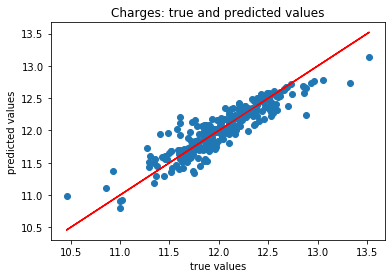

Mean absolute error of the prediction is: 0.12885874941200418
Mean squared error of the prediction is: 0.02988341865051028
Root mean squared error of the prediction is: 0.172868211798787
Mean absolute percentage error of the prediction is: 1.0765115436157937


In [7]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



In the graph, we see that our model is better at predicting values in the middle, than values on the lower right and upper left corner. Looking at some evaluation metrics, this model preforms fairly well. Assuming that MAE, MSE, and RMSE ranges from 0 to 1, the scores for this model are low, thus indicating that the line is a good fit for the model. 

### Iteration 2 

Let's try to improve the fit of the model by dropping some variables that are not statistically significant. The p-values for first floor square feet and house style coeffiecents are not below 0.05 so we will remove them from the explanatory variables. 

In [8]:
# Dummy column with only mszoning 
houseprices_df = pd.concat([houseprices_df,pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)

new_dummy_column_name = list(pd.get_dummies(houseprices_df.mszoning, prefix="mszoning", drop_first=True).columns)

In [9]:
# Y is the target variable
Y = np.log1p(houseprices_df['saleprice'])
# X is the feature set
X = houseprices_df[['overallqual','grlivarea','garagearea','totalbsmtsf', 'int_over_sf'] + new_dummy_column_name]

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [11]:
# We add constant to the model as it's a best practice
# to do so ever ytime!
X_train = sm.add_constant(X_train)

# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     609.2
Date:                Mon, 12 Aug 2019   Prob (F-statistic):               0.00
Time:                        13:54:06   Log-Likelihood:                 441.77
No. Observations:                1168   AIC:                            -863.5
Df Residuals:                    1158   BIC:                            -812.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           9.8303      0.077    127.551      

From the summary, we can see that all of our coefficents are now statistically signifcant. The R-squared and adjusted R-squared is 0.826 to 0.824 respectively. This is slightly less than the previous model that was able to explain 0.2% more variation in the target variable. However, the F statistics did increase from 328.4 to 609.2 in this model. 

Let's continue by looking at some evaluation mertics. 

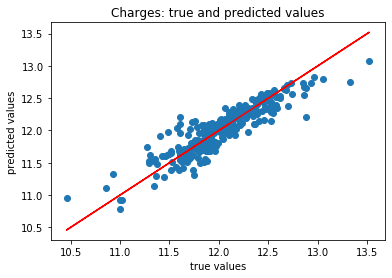

Mean absolute error of the prediction is: 0.12865334418676325
Mean squared error of the prediction is: 0.030055188691633386
Root mean squared error of the prediction is: 0.1733643235836987
Mean absolute percentage error of the prediction is: 1.0751108313234523


In [12]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))



All of the evaluation mterics remained basically the same expect for MSE increasing by 0.002. 

I would choose to continue working with the first model since every metric in the first model preforms better predictions in the test set.  